## Import the necessary packages

In [1]:
print("begining import...")
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras


# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text
from sklearn.model_selection import train_test_split


print("[+] Using Keras version",keras.__version__)


SyntaxError: invalid syntax (<ipython-input-1-1eb55afc3bb3>, line 3)

In [81]:
  CSV_DATA_URL = "https://raw.githubusercontent.com/orzymandias/emotify-model/master/data/data.csv"
  df = pd.read_csv(CSV_DATA_URL, names=["content", "sentiment"])
  df.head()

,content,sentiment
0,I hope all the Romo haters see how much we nee...,anger
1,When your boyfriend promised he'd take you for...,anger
2,The whole fucking team did their part EXCEPT K...,anger
3,@hannah_wootton @JessicaTidball @millyharrison...,anger
4,@CANDYCORNTIME and I never rap battled. #pissed,anger


In [54]:
df = df.drop_duplicates(subset=['content'], keep='first')  # remove duplicate data
df = df[(df.sentiment == "sadness") # filtering emotions of interest
    | (df.sentiment == "anger") 
    | (df.sentiment == "joy")
    | (df.sentiment == "happiness")
    | (df.sentiment == "fun") 
    | (df.sentiment == "fearful")
    | (df.sentiment == "fear") 
    | (df.sentiment == "hate")
    | (df.sentiment == "hate")
    | (df.sentiment == "empty")]
df = df.reset_index(drop=True)
print(df.shape)
df.head()

(48266, 2)


,content,sentiment
0,I hope all the Romo haters see how much we nee...,anger
1,When your boyfriend promised he'd take you for...,anger
2,The whole fucking team did their part EXCEPT K...,anger
3,@hannah_wootton @JessicaTidball @millyharrison...,anger
4,@CANDYCORNTIME and I never rap battled. #pissed,anger


#### Data Imbalance
We discover that we have an imbalanced dataset - there are overlapping categories and disproportional categories.




In [ ]:
print(df.sentiment.value_counts())
df['sentiment'].value_counts().plot(kind='bar')


#### Actions to be taken:

*   Merge the happiness, joy and fun
*   Merge the anger and hate classes
*   Merge the sadness and empty classes
*   Merge the worry and fear classes
* Down-sampling the majority class ensure balance

In [ ]:

df.dropna(inplace = True)
df["sentiment"] = df["sentiment"].replace({'empty': 'sadness', "hate": "anger","fun": "happiness",  "joy": "happiness", "fearful": "fear"})
print(df.sentiment.value_counts())


#### Downsampling to achieve balance 

* Achieving balance is critical to ensure tha tt the model is not overtrained and overfits for a particular feature


In [69]:
happiness, worry, sadness, anger = df.sentiment.value_counts()
df_fear = df[df["sentiment"] == "fear"].sample(10000)
df_happiness = df[df["sentiment"] == "happiness"].sample(10000)
df_sadness = df[df["sentiment"] == "sadness"].sample(10000)
df_anger = df[df["sentiment"] == "anger"].sample(10000)
df = pd.concat([df_fear, df_happiness, df_sadness, df_anger], axis=0)

df.reset_index(drop=True, inplace=True)
print(df.sentiment.value_counts())


happiness    10000
fear         10000
anger        10000
sadness      10000
Name: sentiment, dtype: int64


### Key Metrics of usable dataset
  * Number of samples: 40,000
  * Number of classes: 4
  * Number of samples per class: 4000/5000
  * Median words per sample: 14
  * Samples/words-per-sample ratio: 1357 (borderline 1500)

In [ ]:
def get_num_words_per_sample(sample_texts):
    """Returns the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)
print("\n\nMedian number of words per sample: ", get_num_words_per_sample(df['content']))


## Preprocessing and Data Cleaning






#### Encoding Emotions to Ids

* 0 - anger  
* 1 - fear
* 2 - happiness
* 3 - sadness



In [ ]:
df['sentiment'] = pd.Categorical(df['sentiment'])
df['sentiment'] = df.sentiment.cat.codes
df.head(17888)

#### Clean tweets



In [18]:
!pip install tweet-preprocessor
import preprocessor as p
import nltk
nltk.download('stopwords')

Defaulting to user installation because normal site-packages is not writeable
  Using cached tweet-preprocessor-0.6.0.tar.gz (14 kB)
    ERROR: Command errored out with exit status 1:
     command: /usr/bin/python -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-8a4eAZ/tweet-preprocessor/setup.py'"'"'; __file__='"'"'/tmp/pip-install-8a4eAZ/tweet-preprocessor/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /tmp/pip-pip-egg-info-IhNxLk
         cwd: /tmp/pip-install-8a4eAZ/tweet-preprocessor/
    Complete output (5 lines):
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "/tmp/pip-install-8a4eAZ/tweet-preprocessor/setup.py", line 4, in <module>
        with open('README.rst', encoding='utf-8', errors='ignore') as f:
    TypeError: 'errors' is an invalid keyword argument for t

ModuleNotFoundError: No module named 'preprocessor'

In [ ]:
from nltk.corpus import stopwords

print(df.content.head(10))
def clean_sentence(sentence):
    # removing handles and links
    sentence = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",sentence).split())

    # removing stopwords
    # stop_words = list(stopwords.words('english'))   
    # sentence = " ".join([word.lower() for word in sentence.split() if word not in (stop_words)])   
    sentence = " ".join([word.lower() for word in sentence.split()])   
    
    p.set_options(p.OPT.URL, p.OPT.EMOJI)
    return p.clean(sentence)


df['content'] = df['content'].map(lambda x: clean_sentence(x))

print("-------------------- After cleaning--------------------")
print(df.content.head(10))
    

#### Spliting training and test set




In [22]:
sentiment = df.pop("sentiment")
content = df

x_train, y_train, x_test, y_test = train_test_split(content, sentiment, test_size=0.20, shuffle=True, random_state=42)
print(" Training: size", x_train.shape[0])
print(" Validation size:",y_train.shape[0])
training_data, validation_data, training_label, validation_label = np.array(x_train.content), np.array(y_train.content), np.array(x_test), np.array(y_test)



KeyError: 'sentiment'

#### Model Parameters

In [ ]:
TOP_K = 10000
MAX_SEQUENCE_LENGTH = 28
num_classes = 4


#### Tokenization and Vectorization

* Tokenizes the texts into words
* Creates a vocabulary using the top 20,000 tokens
* Converts the tokens into sequence vectors
* Pads the sequences to a fixed sequence length


In [26]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
def sequence_vectorize(train_texts, val_texts):
   
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)
    print("tokenizer", train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)
    print("training_data_vectorized", x_train)
    print("validation_data_vectorized", x_val)

    # Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH)
    x_val = sequence.pad_sequences(x_val, maxlen=MAX_SEQUENCE_LENGTH)
    return x_train, x_val, tokenizer.word_index

training_data_vectorized, validation_data_vectorized, word_index = sequence_vectorize(training_data,validation_data)
print(training_data_vectorized[0].shape)

ModuleNotFoundError: No module named 'keras'

In [29]:
validation_data_vectorized.shape

NameError: name 'validation_data_vectorized' is not defined

####Model 1: sepCNN
  * Tensorflow documentation

In [ ]:
# from tensorflow.python.keras import models
# from tensorflow.python.keras import initializers
# from tensorflow.python.keras import regularizers

# from tensorflow.python.keras.layers import Dense
# from tensorflow.python.keras.layers import Dropout
# from tensorflow.python.keras.layers import Embedding
# from tensorflow.python.keras.layers import SeparableConv1D
# from tensorflow.python.keras.layers import MaxPooling1D
# from tensorflow.python.keras.layers import GlobalAveragePooling1D

# def sepcnn_model(blocks,
#                  filters,
#                  kernel_size,
#                  embedding_dim,
#                  dropout_rate,
#                  pool_size,
#                  input_shape,
#                  num_classes,
#                  num_features):

#     op_units, op_activation = num_classes, "softmax"
#     model = models.Sequential()
#     model.add(Embedding(input_dim=TOP_K + 1,
#                           output_dim=embedding_dim,
#                           input_length=input_shape))

#     for _ in range(blocks-1):
#         model.add(Dropout(rate=dropout_rate))
#         model.add(SeparableConv1D(filters=filters,
#                                   kernel_size=kernel_size,
#                                   activation='relu',
#                                   bias_initializer='random_uniform',
#                                   depthwise_initializer='random_uniform',
#                                   padding='same'))
#         model.add(SeparableConv1D(filters=filters,
#                                   kernel_size=kernel_size,
#                                   activation='relu',
#                                   bias_initializer='random_uniform',
#                                   depthwise_initializer='random_uniform',
#                                   padding='same'))
#         model.add(MaxPooling1D(pool_size=pool_size))

#     model.add(SeparableConv1D(filters=filters * 2,
#                               kernel_size=kernel_size,
#                               activation='relu',
#                               bias_initializer='random_uniform',
#                               depthwise_initializer='random_uniform',
#                               padding='same'))
#     model.add(SeparableConv1D(filters=filters * 2,
#                               kernel_size=kernel_size,
#                               activation='relu',
#                               bias_initializer='random_uniform',
#                               depthwise_initializer='random_uniform',
#                               padding='same'))
#     model.add(GlobalAveragePooling1D())
#     model.add(Dropout(rate=dropout_rate))
#     model.add(Dense(op_units, activation=op_activation))
#     model.summary()
#     return model

# model = sepcnn_model(blocks=2,
#                      filters=64,
#                      kernel_size=3,  # Kenel size: recommended 3 or 5
#                      dropout_rate=0.3, # Dropout rate, reccomended range: 0.2–0.5.,
#                      pool_size=3, 
#                      num_classes=4,
#                      input_shape= MAX_SEQUENCE_LENGTH,
#                      embedding_dim=200, # Embedding Dimension: size of each word vector. Recommended values: 50–300
#                      num_features=TOP_K)

#### Model 2: CNN

* loss: 0.8516 - acc: 0.6304 - val_loss: 0.8652 - val_acc: 0.6229
* loss: 0.8539 - acc: 0.6303 - val_loss: 0.8567 - val_acc: 0.6270

In [32]:
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers

from keras import models
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer

def cnn_Model(dropout_rate, num_classes):
    model = models.Sequential()
    model.add(Embedding(TOP_K + 1,
                        50,
                        input_length=MAX_SEQUENCE_LENGTH))
    model.add(Dropout(dropout_rate))
    model.add(Conv1D(64,
                     4,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(256))
    model.add(Dropout(dropout_rate))
    model.add(Activation('relu'))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(num_classes, activation="sigmoid"))
    # model.add(Dense(num_classes, activation="softmax"))
    model.summary()

    return model



model = cnn_Model(num_classes=num_classes, dropout_rate=0.2)


ModuleNotFoundError: No module named 'keras'

####Model 3: RNN LSTM Model
* Performance
  * loss: 0.8149 - acc: 0.6585 - val_loss: 0.8769 - val_acc: 0.6173
  * loss: 0.8156 - acc: 0.6591 - val_loss: 0.8729 - val_acc: 0.6227



In [35]:
from keras import models
from keras.layers import Embedding, Dense, LSTM, Dropout, SpatialDropout1D

def lstm_RNN(num_classes, dropout_rate):
    model = models.Sequential()
    model.add(Embedding(TOP_K,
                        200,
                        input_length=MAX_SEQUENCE_LENGTH))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(50, dropout=dropout_rate, recurrent_dropout=0.3))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation="softmax"))
    model.summary()
    return model

model = lstm_RNN(4, 0.2)

ModuleNotFoundError: No module named 'keras'


#### Model 4: Pretrained Embedded Model with MLP
* Performance
  * loss: 0.9027 - acc: 0.6317 - val_loss: 1.0744 - val_acc: 0.5468





* Import TFhub

In [ ]:
!pip install -q tensorflow-hub



In [50]:
from keras import models
import tensorflow_hub as hub
import tensorflow_datasets as tfds

embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

def transferEmbedding(layers, units, dropout_rate, num_classes):
  model = tf.keras.Sequential()
  model.add(hub_layer)

  for _ in range(layers-1):
        model.add(tf.keras.layers.Dense(units=units, activation='relu'))
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))
        model.add(tf.keras.layers.Dense(num_classes, activation="softmax"))
        # model.add(tf.keras.layers.Dense(num_classes, activation="sigmoid"))

  model.summary()
  return model

model = transferEmbedding(3, 32, 0.3, 2)

ModuleNotFoundError: No module named 'keras'

#### Model 5: RNN LSTM2
  * 0.7894 - acc: 0.6669 - val_loss: 0.8719 - val_acc: 0.6285

In [ ]:
def RNN_LSTM2(dropout_rate):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(TOP_K, 200, input_length=training_data_vectorized.shape[1]))
  model.add(tf.keras.layers.SpatialDropout1D(dropout_rate))
  model.add(tf.keras.layers.LSTM(50, dropout=dropout_rate, recurrent_dropout=0.2))
  model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
  model.summary()
  return model

RNN_LSTM2(0.2)

#### Hyperparameters

In [70]:
learning_rate = 1e-4
batch_size = 64
epochs =20
dropout_rate=0.2
kernel_size = 3


#### Training

* https://ruder.io/optimizing-gradient-descent/

In [ ]:


# Initlize Model
model = cnn_Model(num_classes=num_classes, dropout_rate=dropout_rate)
# model = lstm_RNN(num_classes=num_classes, dropout_rate=dropout_rate)
# model = transferEmbedding(layers=2, units=64, dropout_rate=dropout_rate, num_classes=num_classes)
# model = RNN_LSTM2(dropout_rate=dropout_rate)


callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['acc'])
# model.compile(optimizer="adadelta", loss='sparse_categorical_crossentropy', metrics=['acc'])

# Fit Model
# remember to switch training data depending on model
history = model.fit(
            training_data_vectorized,
            training_label,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(validation_data_vectorized, validation_label),
            verbose=1,  # Logs once per epoch.
            batch_size=batch_size)


Plot loss graph

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

### Model Evaluation

In [200]:
loss,acc = model.evaluate(validation_data_vectorized,  validation_label, verbose=2)
print("model accuracy: {:5.2f}% \nmodel loss {:5.2f}".format(100*acc, loss))


model accuracy: 76.94% 
model loss  0.58


              precision    recall  f1-score   support

       anger       0.83      0.77      0.80      2000
        fear       0.93      0.88      0.91      2047
   happiness       0.66      0.79      0.72      1967
     sadness       0.67      0.64      0.65      1986

    accuracy                           0.77      8000
   macro avg       0.78      0.77      0.77      8000
weighted avg       0.78      0.77      0.77      8000



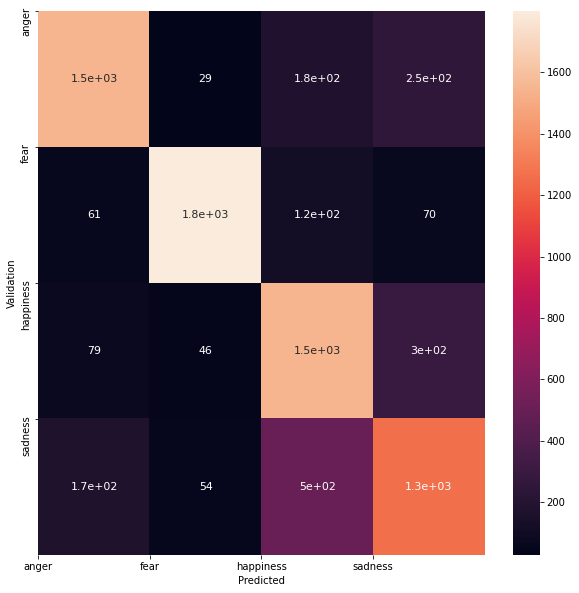

In [202]:
 from sklearn.metrics import classification_report, confusion_matrix
 import seaborn as sn


#  labels = ["anger", "happiness", "sadness","worry"]
 labels = ["anger", "fear", "happiness", "sadness"]

 predictions = model.predict(validation_data_vectorized)
 predictions = np.argmax(predictions,axis=1)

print(classification_report(validation_label, predictions, target_names=labels))


matrix = confusion_matrix(validation_label, predictions)
plt.figure(figsize=(10,10))
sn.heatmap(matrix, annot=True, annot_kws={"size": 11}) # font size
plt.xlabel('Predicted')
plt.ylabel('Validation')
plt.xticks(np.arange(4), labels)
plt.yticks(np.arange(4), labels)

plt.show()

In [212]:
from tensorflow.python.keras.preprocessing import text

def tokenize_and_pad(input):
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(training_data)
    tokenized = tokenizer.texts_to_sequences(input)
    padded = sequence.pad_sequences(tokenized, maxlen=MAX_SEQUENCE_LENGTH)
    return padded

def predict_emo(input):
    encoded = tokenize_and_pad([input])
    return model.predict(encoded)

'''
  non transfer learning models
  labels = ["anger", "fear", "happiness", "sadness"]
'''
emotion = np.argmax(predict_emo("he's so scary"))
print(f"Predicted emotion: {labels[emotion]}")

emotion = np.argmax(predict_emo("I am over the moon"))
print(f"Predicted emotion: {labels[emotion]}")

emotion = np.argmax(predict_emo("dont hurt me"))
print(f"Predicted emotion: {labels[emotion]}")

emotion = np.argmax(predict_emo("I hate you, never want to see you again"))
print(f"Predicted emotion: {labels[emotion]}")

# transfer learning model
# model.predict(["I am in pain"])


Predicted emotion: fear
Predicted emotion: happiness
Predicted emotion: sadness
Predicted emotion: anger


####Save Model


In [0]:
model.save('test.h5')
